# Training Models to predict Sentiment 

In this notebook, we will train various models using the cleaned movie review dataset (refer to **cleaning** notebook for pre processing steps) to predict the sentiment and evaluate the performance of each

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import os
import sys
import optuna
from transformer_block import TransformerBlock
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import logging

In [8]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
imdb_data = pd.read_csv('../data/clean/cleaned_imdb_data.csv')
imdb_data

,review,sentiment,padded_sequences
0,one reviewer mentioned watching 1 oz episode y...,positive,[ 4 1023 946 68 417 3107 178 3...
1,wonderful little production filming technique ...,positive,[ 293 47 241 1236 1611 15988 1 13...
2,thought wonderful way spend tear eye hot summe...,positive,[ 97 293 26 994 12 8 788 13...
3,basically there family little boy jake think t...,negative,[ 584 134 125 47 207 3362 31 1...
4,petter matteis love tear eye money visually st...,positive,[ 1 1 36 12 8 200 1977 12...
...,...,...,...
49995,thought movie right good job wasnt creative or...,positive,[ 97 2 107 6 182 192 1348 120 25 ...
49996,bad plot bad dialogue bad acting idiotic direc...,negative,[ 22 41 22 286 22 45 2748 8...
49997,catholic taught parochial elementary school nu...,negative,[ 2958 3919 1 7505 266 4122 3919 ...
49998,im going disagree previous comment side maltin...,negative,[ 66 79 2760 777 345 352 10353 ...


Lets first format the **padded_sequences** column so it can be treated like a list :

In [10]:
def fix_sequence_format(sequence_str):
    # Remove extra spaces and convert to proper list format
    sequence_str = re.sub(r'\s+', ',', sequence_str.strip())  
    sequence_str = sequence_str.replace('[,', '[')  
    sequence_str = sequence_str.replace(',]', ']')  
    return eval(sequence_str) 

imdb_data['padded_sequences'] = imdb_data['padded_sequences'].apply(fix_sequence_format)

In [11]:
imdb_data.head()

,review,sentiment,padded_sequences
0,one reviewer mentioned watching 1 oz episode y...,positive,"[4, 1023, 946, 68, 417, 3107, 178, 369, 2916, ..."
1,wonderful little production filming technique ...,positive,"[293, 47, 241, 1236, 1611, 15988, 1, 1357, 61,..."
2,thought wonderful way spend tear eye hot summe...,positive,"[97, 293, 26, 994, 12, 8, 788, 1304, 2215, 107..."
3,basically there family little boy jake think t...,negative,"[584, 134, 125, 47, 207, 3362, 31, 134, 525, 3..."
4,petter matteis love tear eye money visually st...,positive,"[1, 1, 36, 12, 8, 200, 1977, 1252, 3, 35, 284,..."


Lets now preprocess the **IMDB dataset** by converting sentiment labels to numerical values (0 for negative, 1 for positive) and split the data into training, validation, and testing sets using stratified sampling to maintain the class balance :

In [12]:
# Convert labels to numerical values (0 for negative, 1 for positive)
imdb_data['sentiment'] = imdb_data['sentiment'].map({'negative': 0, 'positive': 1})
X = imdb_data['padded_sequences'].tolist()
y = imdb_data['sentiment']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

#split train_val into 70% train and 15% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, random_state=42, stratify=y_train_val
)  # 0.176 ensures 15% of the original dataset goes to validation


In [13]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [14]:
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype, X_val.dtype, y_val.dtype)

int32 int32 int64 int64 int32 int64


In [15]:
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_val = y_val.astype(np.int32)

In [16]:
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype, X_val.dtype, y_val.dtype)

int32 int32 int32 int32 int32 int32


In [17]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(35020, 300) (35020,) (7500, 300) (7500,) (7480, 300) (7480,)


***

#### For an initial baseline, I have chosen an LSTM based model. LSTM's are a decent choice as they are well-established for sequence modeling tasks like sentiment analysis. They can effectively capture the temporal dependencies and sequential patterns in text data, handling long input sequences better than simple RNNs. Given the relatively moderate size and complexity of the IMDB dataset, LSTMs provide a strong and reliable starting point, offering competitive performance with manageable computational requirements.

## Model Architecture 

**Embedding Layer** :

-   Converts tokenized words into dense vector representations of size 128

-   Supports a vocabulary size of 20,000 words.


**First LSTM Layer** :

-   128 LSTM units capture long-range dependencies in text sequences

-   **return_sequences=True** ensures it passes the full sequence to the next layer.

**Second LSTM Layer** :

-  64 LSTM units extract deeper sequential features


-   **return_sequences=False** outputs only the final hidden state (a single vector).


**Dense Output Layer** :

-   A single neuron with sigmoid activation for binary classification (positive/negative sentiment).

#### Additional Components :

-   **Early Stopping** : Stops training if validation loss doesn’t improve for 3 epochs and restores the best model.

-   **Adam Optimizer** : Adaptive optimization for stable and efficient training.

In [25]:
model = Sequential([
    Embedding(input_dim=20000, output_dim=128), 
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=False), 
    Dense(1, activation='sigmoid')  
])

early_stopping = EarlyStopping(
    monitor="val_loss",  
    patience=3,           
    restore_best_weights=True
)

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [26]:
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 226s 407ms/step - accuracy: 0.5016 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 233s 425ms/step - accuracy: 0.5097 - loss: 0.6892 - val_accuracy: 0.5015 - val_loss: 0.6944
Epoch 3/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 250s 456ms/step - accuracy: 0.5222 - loss: 0.6676 - val_accuracy: 0.5035 - val_loss: 0.7103
Epoch 4/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 253s 462ms/step - accuracy: 0.6225 - loss: 0.6126 - val_accuracy: 0.8290 - val_loss: 0.4396
Epoch 5/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 253s 461ms/step - accuracy: 0.8567 - loss: 0.3601 - val_accuracy: 0.8711 - val_loss: 0.3358
Epoch 6/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 254s 463ms/step - accuracy: 0.9210 - loss: 0.2246 - val_accuracy: 0.8678 - val_loss: 0.3735
Epoch 7/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 258s 470ms/step - accuracy: 0.9493 - loss: 0.1584 - val_accuracy: 0.8703 - val_loss: 0.3971
Epoch 8/15
548/548 ━━━━━━━━━━━━━━━━━━━━ 255s 466ms/step - accuracy: 0.9638 -

In [27]:
model.save('./baseline_models/LSTM_model.h5')

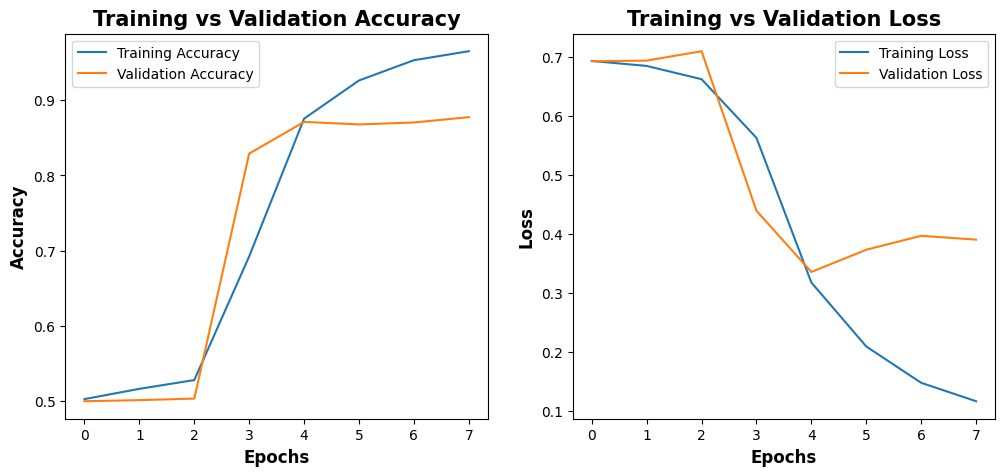

In [28]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create subplots
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Training vs Validation Accuracy', fontsize=15, fontweight='bold')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('Training vs Validation Loss', fontsize=15, fontweight='bold')
plt.legend()

plt.show()

## Interpretation of Graphs :

**Training vs Validation Accuracy (Left Plot)** :

-   Training accuracy keeps increasing

-   Validation accuracy peaks (~85%) around epoch 4 and then slightly declines/steadies out

-   Indicates overfitting : The model learns the training data too well but struggles to generalize

**Training vs Validation Loss (Right Plot)** :

-   Training loss keeps decreasing, showing continuous learning

-   Validation loss decreases initially but starts rising after epoch 4

-   This suggests the model stops generalizing and starts memorizing, leading to overfitting.

Overall, the model performs well early but overfits after a few epochs. Lets perform hyperparameter tuning and incorporate techniques like **Dropout** etc to see if we can improve the performance of the model  

***

## Hyperparameter Tuning 

-   To parameter tune the model, I used a framework called **Optuna** that uses a smart, adaptive search strategy to find the best hyperparameter settings for a model

-   Instead of exhaustively trying every combination (like grid search), Optuna uses a technique called Bayesian optimization (specifically, the Tree-structured Parzen Estimator or TPE) to model which hyperparameter combinations are most promising based on past trials. It then shifts future trials toward the most promising parts of the search space, helping the tuning process move faster and get better results more efficiently

-   In each trial, Optuna samples a new set of hyperparameters, trains the model, evaluates its performance (e.g. using validation loss), and updates its strategy to improve future suggestions. This leads to finding better models with fewer trials and less computational effort compared to manual or random search.

In [53]:
save_dir = "param_tuned_models"
os.makedirs(save_dir, exist_ok=True)
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s', stream=sys.stdout, force=True)

vocab_size = 20000

In [ ]:
def build_lstm_model(trial):
    embedding_dim = trial.suggest_categorical('embedding_dim', [64, 100, 128, 200])
    lstm1_units = trial.suggest_categorical('lstm1_units', [64, 128, 256])
    lstm2_units = trial.suggest_categorical('lstm2_units', [32, 64, 128])
    dropout_rate = trial.suggest_float('dropout', 0.2, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)

    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        LSTM(lstm1_units, return_sequences=True),
        LSTM(lstm2_units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model, {
        'embedding_dim': embedding_dim,
        'lstm1_units': lstm1_units,
        'lstm2_units': lstm2_units,
        'dropout': dropout_rate,
        'learning_rate': learning_rate
    }

In [55]:
def objective(trial):
    trial_id = trial.number
    logging.info(f"Trial {trial_id} Starting...")

    model, params = build_lstm_model(trial)

    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    params['batch_size'] = batch_size

    logging.info(f"Trial {trial_id} Hyperparameters: {params}")

    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=8,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=0
    )

    best_val_loss = min(history.history['val_loss'])

    model_path = os.path.join(save_dir, f"trial_{trial_id}.h5")
    model.save(model_path)

    logging.info(f"Trial {trial_id} Completed | val_loss = {best_val_loss:.4f} | Model saved to {model_path}")
    return best_val_loss

In [ ]:
study = optuna.create_study(
    direction='minimize', 
    study_name='lstm_param_tuning'
)

study.optimize(objective, n_trials=10) 

print("Best trial:")
print(f"Trial #{study.best_trial.number}")
print(f"Validation loss: {study.best_trial.value:.4f}")
print("Hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

[I 2025-04-01 19:19:44,281] A new study created in memory with name: lstm_param_tuning


2025-04-01 19:19:44,282 [INFO] Trial 0 Starting...
2025-04-01 19:19:44,334 [INFO] Trial 0 Hyperparameters: {'embedding_dim': 200, 'lstm1_units': 128, 'lstm2_units': 128, 'dropout': 0.23526464807433956, 'learning_rate': 0.00041216282681529314, 'batch_size': 64}
2025-04-01 19:43:52,358 [WARNING] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-04-01 19:43:52,406 [INFO] Trial 0 Completed | val_loss = 0.6914 | Model saved to param_tuned_models\trial_0.h5


[I 2025-04-01 19:43:52,408] Trial 0 finished with value: 0.6914156079292297 and parameters: {'embedding_dim': 200, 'lstm1_units': 128, 'lstm2_units': 128, 'dropout': 0.23526464807433956, 'learning_rate': 0.00041216282681529314, 'batch_size': 64}. Best is trial 0 with value: 0.6914156079292297.


2025-04-01 19:43:52,409 [INFO] Trial 1 Starting...
2025-04-01 19:43:52,420 [INFO] Trial 1 Hyperparameters: {'embedding_dim': 64, 'lstm1_units': 64, 'lstm2_units': 32, 'dropout': 0.2861115618947169, 'learning_rate': 0.0005373388844378002, 'batch_size': 32}
2025-04-01 19:58:52,045 [WARNING] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-04-01 19:58:52,072 [INFO] Trial 1 Completed | val_loss = 0.3002 | Model saved to param_tuned_models\trial_1.h5


[I 2025-04-01 19:58:52,073] Trial 1 finished with value: 0.3001664876937866 and parameters: {'embedding_dim': 64, 'lstm1_units': 64, 'lstm2_units': 32, 'dropout': 0.2861115618947169, 'learning_rate': 0.0005373388844378002, 'batch_size': 32}. Best is trial 1 with value: 0.3001664876937866.


2025-04-01 19:58:52,074 [INFO] Trial 2 Starting...
2025-04-01 19:58:52,085 [INFO] Trial 2 Hyperparameters: {'embedding_dim': 200, 'lstm1_units': 256, 'lstm2_units': 64, 'dropout': 0.4936275755687515, 'learning_rate': 0.0002885787839078332, 'batch_size': 64}
2025-04-01 20:35:53,284 [WARNING] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-04-01 20:35:53,371 [INFO] Trial 2 Completed | val_loss = 0.6860 | Model saved to param_tuned_models\trial_2.h5


[I 2025-04-01 20:35:53,372] Trial 2 finished with value: 0.6859517097473145 and parameters: {'embedding_dim': 200, 'lstm1_units': 256, 'lstm2_units': 64, 'dropout': 0.4936275755687515, 'learning_rate': 0.0002885787839078332, 'batch_size': 64}. Best is trial 1 with value: 0.3001664876937866.


2025-04-01 20:35:53,373 [INFO] Trial 3 Starting...
2025-04-01 20:35:53,383 [INFO] Trial 3 Hyperparameters: {'embedding_dim': 200, 'lstm1_units': 128, 'lstm2_units': 32, 'dropout': 0.33372966243572644, 'learning_rate': 0.0001147539844259012, 'batch_size': 64}
2025-04-01 21:00:20,164 [WARNING] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-04-01 21:00:20,250 [INFO] Trial 3 Completed | val_loss = 0.6099 | Model saved to param_tuned_models\trial_3.h5


[I 2025-04-01 21:00:20,252] Trial 3 finished with value: 0.6099440455436707 and parameters: {'embedding_dim': 200, 'lstm1_units': 128, 'lstm2_units': 32, 'dropout': 0.33372966243572644, 'learning_rate': 0.0001147539844259012, 'batch_size': 64}. Best is trial 1 with value: 0.3001664876937866.


2025-04-01 21:00:20,253 [INFO] Trial 4 Starting...
2025-04-01 21:00:20,265 [INFO] Trial 4 Hyperparameters: {'embedding_dim': 128, 'lstm1_units': 64, 'lstm2_units': 64, 'dropout': 0.32195107804878675, 'learning_rate': 0.00014480466473277637, 'batch_size': 64}
2025-04-01 21:10:47,860 [WARNING] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-04-01 21:10:47,895 [INFO] Trial 4 Completed | val_loss = 0.6846 | Model saved to param_tuned_models\trial_4.h5


[I 2025-04-01 21:10:47,896] Trial 4 finished with value: 0.6845627427101135 and parameters: {'embedding_dim': 128, 'lstm1_units': 64, 'lstm2_units': 64, 'dropout': 0.32195107804878675, 'learning_rate': 0.00014480466473277637, 'batch_size': 64}. Best is trial 1 with value: 0.3001664876937866.


2025-04-01 21:10:47,897 [INFO] Trial 5 Starting...
2025-04-01 21:10:47,909 [INFO] Trial 5 Hyperparameters: {'embedding_dim': 100, 'lstm1_units': 64, 'lstm2_units': 64, 'dropout': 0.347825590586919, 'learning_rate': 0.00011622442724482618, 'batch_size': 32}
2025-04-01 21:28:55,721 [WARNING] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-04-01 21:28:55,792 [INFO] Trial 5 Completed | val_loss = 0.6806 | Model saved to param_tuned_models\trial_5.h5


[I 2025-04-01 21:28:55,794] Trial 5 finished with value: 0.6806046962738037 and parameters: {'embedding_dim': 100, 'lstm1_units': 64, 'lstm2_units': 64, 'dropout': 0.347825590586919, 'learning_rate': 0.00011622442724482618, 'batch_size': 32}. Best is trial 1 with value: 0.3001664876937866.


2025-04-01 21:28:55,795 [INFO] Trial 6 Starting...
2025-04-01 21:28:55,809 [INFO] Trial 6 Hyperparameters: {'embedding_dim': 128, 'lstm1_units': 256, 'lstm2_units': 64, 'dropout': 0.4261662856039429, 'learning_rate': 0.0006178058054133829, 'batch_size': 32}
2025-04-01 22:11:23,431 [WARNING] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-04-01 22:11:23,511 [INFO] Trial 6 Completed | val_loss = 0.6875 | Model saved to param_tuned_models\trial_6.h5


[I 2025-04-01 22:11:23,512] Trial 6 finished with value: 0.6875154972076416 and parameters: {'embedding_dim': 128, 'lstm1_units': 256, 'lstm2_units': 64, 'dropout': 0.4261662856039429, 'learning_rate': 0.0006178058054133829, 'batch_size': 32}. Best is trial 1 with value: 0.3001664876937866.


2025-04-01 22:11:23,513 [INFO] Trial 7 Starting...
2025-04-01 22:11:23,523 [INFO] Trial 7 Hyperparameters: {'embedding_dim': 64, 'lstm1_units': 128, 'lstm2_units': 64, 'dropout': 0.299978434153229, 'learning_rate': 0.00026900878621151565, 'batch_size': 32}
2025-04-01 22:27:19,262 [WARNING] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-04-01 22:27:19,328 [INFO] Trial 7 Completed | val_loss = 0.6882 | Model saved to param_tuned_models\trial_7.h5


[I 2025-04-01 22:27:19,329] Trial 7 finished with value: 0.688231348991394 and parameters: {'embedding_dim': 64, 'lstm1_units': 128, 'lstm2_units': 64, 'dropout': 0.299978434153229, 'learning_rate': 0.00026900878621151565, 'batch_size': 32}. Best is trial 1 with value: 0.3001664876937866.


2025-04-01 22:27:19,330 [INFO] Trial 8 Starting...
2025-04-01 22:27:19,341 [INFO] Trial 8 Hyperparameters: {'embedding_dim': 200, 'lstm1_units': 128, 'lstm2_units': 128, 'dropout': 0.3914590909502659, 'learning_rate': 0.0007136709774178373, 'batch_size': 64}
2025-04-01 22:46:35,804 [WARNING] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-04-01 22:46:35,890 [INFO] Trial 8 Completed | val_loss = 0.6931 | Model saved to param_tuned_models\trial_8.h5


[I 2025-04-01 22:46:35,891] Trial 8 finished with value: 0.6930783987045288 and parameters: {'embedding_dim': 200, 'lstm1_units': 128, 'lstm2_units': 128, 'dropout': 0.3914590909502659, 'learning_rate': 0.0007136709774178373, 'batch_size': 64}. Best is trial 1 with value: 0.3001664876937866.


2025-04-01 22:46:35,891 [INFO] Trial 9 Starting...
2025-04-01 22:46:35,903 [INFO] Trial 9 Hyperparameters: {'embedding_dim': 200, 'lstm1_units': 128, 'lstm2_units': 128, 'dropout': 0.374007906709645, 'learning_rate': 0.0006618478787374257, 'batch_size': 64}
2025-04-01 23:11:37,904 [WARNING] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-04-01 23:11:37,989 [INFO] Trial 9 Completed | val_loss = 0.6897 | Model saved to param_tuned_models\trial_9.h5


[I 2025-04-01 23:11:37,991] Trial 9 finished with value: 0.6896740794181824 and parameters: {'embedding_dim': 200, 'lstm1_units': 128, 'lstm2_units': 128, 'dropout': 0.374007906709645, 'learning_rate': 0.0006618478787374257, 'batch_size': 64}. Best is trial 1 with value: 0.3001664876937866.


Best trial:
Trial #1
Validation loss: 0.3002
Hyperparameters:
embedding_dim: 64
lstm1_units: 64
lstm2_units: 32
dropout: 0.2861115618947169
learning_rate: 0.0005373388844378002
batch_size: 32


***

In [5]:
best_model = load_model("./param_tuned_models/trial_1.h5")
baseline_model = load_model('./baseline_models/LSTM_model.h5')

In [18]:
test_loss, test_acc = baseline_model.evaluate(X_test, y_test)
print(f"Test Accuracy for Baseline Model: {test_acc:.4f}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.8792 - loss: 0.3335
Test Accuracy for Baseline Model: 0.8757


In [19]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy for Tuned Model: {test_acc:.4f}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.8817 - loss: 0.2920
Test Accuracy for Tuned Model: 0.8817


| Model Name       | Parameters Used                                                                                                 | Test Accuracy | Test Loss |
|------------------|------------------------------------------------------------------------------------------------------------------|---------------|-----------|
| **Baseline LSTM** | embedding_dim=128, lstm1_units=128, lstm2_units=64, learning_rate=0.001, batch_size=64 | **87.6%**         | **0.3335**    |
| **Tuned LSTM**    | embedding_dim=64, lstm1_units=64, lstm2_units=32, dropout=0.286, learning_rate=0.000537, batch_size=32 | **88.2%**     | **0.2920** |


### Conclusions 

-  **Hyperparameter tuning led to a slight performance improvement** : The best-tuned LSTM model achieved a test accuracy of 88.2%, slightly outperforming the baseline model’s 87.6%, and reduced test loss from 0.3335 to 0.2920.

-  **Smaller architecture maintained performance while improving efficiency** : Despite using fewer parameters (for eg : embedding_dim=64, lstm1_units=64, lstm2_units=32), the tuned model matched and slightly exceeded the baseline's accuracy, suggesting the baseline was a bit overparameterized 

-  **Better generalization with dropout and lower learning rate** : The tuned model used a dropout rate of 0.286 and a lower learning rate (0.000537), helping stabilize training and reduce overfitting compared to the baseline.

-  **Training efficiency improved** : The tuned model not only performed slightly better but also trained faster (15mins compared to 33mins for baseline), thanks to the smaller architecture and reduced batch size (32 vs. 64)

-  Overall, while the performance gain was not dramatic, the tuning process led to a leaner model with slightly better generalization and more efficient training.

***

### We will now experiment with a couple Transformer models :

-   Custom Transformer Model

-   Pre Trained BERT Model (taken from [Hugging Face](https://huggingface.co/docs/transformers/en/model_doc/bert))

#### Why use Transformers?

Transformers allow the model to look at every word in a sentence simultaneously and learn which words are most important for understanding meaning. This is done through self-attention — instead of processing text word-by-word like RNNs/LSTMs, transformers process all words at once and **pay attention** to the most relevant ones.

Movie reviews are often long and nuanced, containing sarcasm, negations, and context spread across multiple sentences. Transformers may be helpful as :

-   They capture long-range dependencies (e.g : "I thought the film would be great... but it was terrible")

-   They don’t suffer from vanishing gradients like LSTMs sometimes do

-   They focus on the most important words for sentiment (via attention)

We will first train a custom based transformer model to see if it performs better than the LSTM models trained earlier. This will tell us if a small, light transformer (compared to large Pre Trained ones) does a good enough job at predicting sentiment with high accuracy

Then, we will use a Pre Trained Transformer (BERT) and fine tune it with our dataset and compare its performance with the other models. The motivation for using BERT arises because it captures context from both directions (left and right) in a sentence, which allows it to understand the nuances of language more effectively than previous models. Pre-trained on vast amounts of text, BERT has learned a rich understanding of grammar, meaning, and relationships in language

Fine-tuning a pre-trained model like BERT for specific tasks, such as sentiment analysis, is a fast and efficient way to achieve really good results. It lets you leverage the model’s existing knowledge, saving the time and computational resources required to train a large model from scratch. 

***

# Custom Transformer Model

In [67]:
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")  
tokenizer.fit_on_texts(imdb_data['review']) 

In [ ]:
def load_glove_embeddings(glove_file, vocab_size, tokenizer, embedding_dim=200):
    embeddings_index = {}

    # Read the GloVe file
    with open(glove_file, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector

    # Create an embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, index in tokenizer.word_index.items():
        if index < vocab_size:  
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector  

    return embedding_matrix

# Load the embeddings
embedding_matrix = load_glove_embeddings("../glove.6B/glove.6B.200d.txt", vocab_size=20000, tokenizer=tokenizer)

In [ ]:
def create_transformer_model(vocab_size=20000, embed_dim=200, num_heads=4, ff_dim=128, num_transformer_blocks=2, sequence_length=300):
    inputs = Input(shape=(sequence_length,))

    # GloVe embedding layer
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim,
                                 weights=[embedding_matrix], trainable=True)(inputs)

    # Stack Transformer Blocks
    x = embedding_layer
    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    # Pooling + Dense classifier
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

#### Quick Description of Architecture of Model :

**Input Layer** 

-    Takes padded sequences of token IDs (e.g., [12, 45, 78, ...]), each review is of fixed length (300 tokens)

**Embedding Layer (with GloVe)**

-   Maps each token ID to a pretrained GloVe vector (200 dimensions) (Taken from : [Glove Website](https://nlp.stanford.edu/projects/glove/))

-   GloVe (Global Vectors for Word Representation) is a pretrained word embedding model trained on a massive text corpora like Wikipedia. It turns words into dense vectors where semantic relationships are captured. To give the model a strong head start in understanding language, 200-dimensional GloVe vectors were loaded into the embedding layer. These pre-trained word embeddings were mapped to the vocabulary of the IMDB dataset, allowing the model to grasp word meanings and relationships right away. 

**Tranformer Blocks (x2)** 

-   Each block has:

    -   Multi-Head Self-Attention: Lets each word focus on other words in the review.

    -   Feed-Forward Network: Processes each word’s new context-rich vector.

    -   Residual Connections + Layer Normalization: Help with stable and efficient training

**Global Average Pooling**

-   Compresses the sequence of word vectors into a single fixed-size vector.

**Dense Layer**

-   A fully connected layer (64 neurons, ReLU activation) to learn abstract features.

**Dropout Layer**

-   Dropout (0.2) for regularization to prevent overfitting.

**Output Layer**

-   A single neuron with sigmoid activation which outputs the probability of the review being positive.



In [84]:
model = create_transformer_model()

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 908s 2s/step - accuracy: 0.7271 - loss: 0.5260 - val_accuracy: 0.8622 - val_loss: 0.3188
Epoch 2/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 917s 2s/step - accuracy: 0.8634 - loss: 0.3156 - val_accuracy: 0.8691 - val_loss: 0.2948
Epoch 3/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 942s 2s/step - accuracy: 0.8814 - loss: 0.2805 - val_accuracy: 0.8775 - val_loss: 0.2856
Epoch 4/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 1172s 2s/step - accuracy: 0.8956 - loss: 0.2484 - val_accuracy: 0.8782 - val_loss: 0.2939
Epoch 5/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 897s 2s/step - accuracy: 0.9118 - loss: 0.2186 - val_accuracy: 0.8811 - val_loss: 0.3045
Epoch 6/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 888s 2s/step - accuracy: 0.9220 - loss: 0.1934 - val_accuracy: 0.8771 - val_loss: 0.3389


In [89]:
model.save("./baseline_models/transformer_sentiment_model.h5")

2025-04-03 12:39:40,976 [WARNING] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


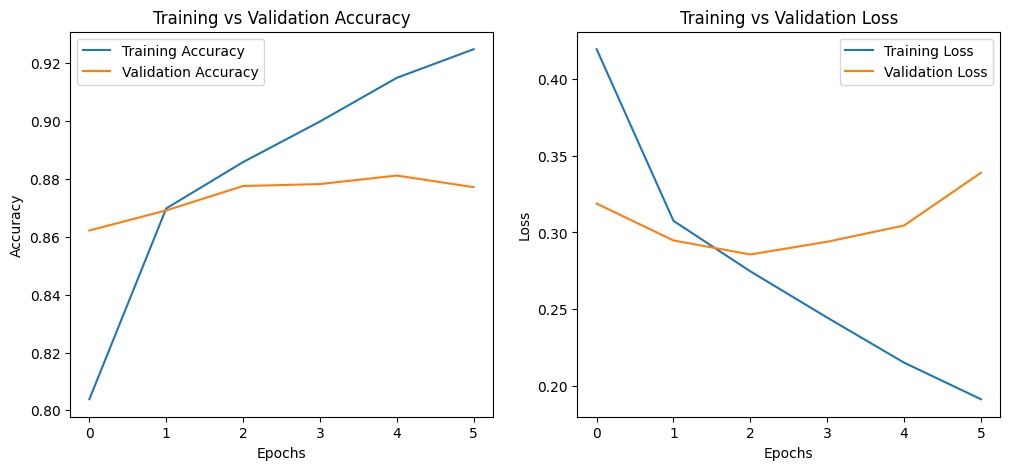

In [ ]:
# Extract accuracy and loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create subplots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [91]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 100s 426ms/step - accuracy: 0.8807 - loss: 0.2804
Test Accuracy: 0.8824


### Custom Transformer Model Results 

**Training vs Validation Accuracy**

-   Training accuracy steadily improved from 80% to 93%, while validation accuracy plateaued around 87-88% after epoch 4-5, showing signs of early overfitting.


**Training vs Validation Loss**

-  Training loss consistently decreased, but validation loss flattened and eventually increased slightly after epoch 2-3, confirming overfitting as the model learned too much from the training data.

**Final Test Accuracy** : Achieved 88.24% test accuracy

**Training Time** : Took approx 95 minutes to train, compared to 15 minutes for the best-tuned LSTM model — over 6x longer.   




From the above, we can see the transformer model only performed slighlty better than the best tuned-LSTM model even though we expected to see a bigger improvement. Here's a couple possible reasons why the Transformer only slightly outperformed the LSTM model :

-  **Small Transformer Model** : The Transformer model used was also relatively small, with just two blocks and four attention heads. While Transformers are known for their ability to model long-range dependencies through self-attention, smaller models may not fully leverage this potential, which may have lead to very minimal improvements as we saw

-  **Higher Computational Overhead** : Transformers tend to have higher computational overhead due to the self-attention mechanism, which can scale poorly with longer input sequences. For moderately long texts like movie reviews, this could have made the Transformer less efficient without offering a significant accuracy benefit, especially when compared to the more lightweight and sequentially efficient LSTM model

***

#### Now that we have seen the results of the custon transformer model, lets fine-tune the Pre trained **BERT** model to see if we get better improvements 

#### Please check **bert_model.ipynb** to see the implemenation and results of the fine tuned model

#### Notes :

-   I have made a separate notebook for the **BERT** model since it requires very specific versions of **torch**, **tensorflow** and **cuda** which were causing dependency issues in the current python environment. So to keep things simple I made a separate environment with the right versions of all the dependencies 

-   the list of all libraries/dependencies with their respective versions can be found in **requirements_bert.txt**. Also please refer to **README.md** for some additional commands to ensure **torch** is set up with **cuda** correctly for GPU acceleration (for systems with a GPU) 